<a href="https://colab.research.google.com/github/liyachittilappilly/abs/blob/main/Untitled26.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Contents of dataset directory:
['3', '0']

Number of '0' (no abs) images: 8
Number of '3' (abs) images: 17
Found 21 images belonging to 2 classes.
Found 4 images belonging to 2 classes.

Class indices: {'0': 0, '3': 1}
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 994ms/step

Train features shape: (21, 8192)
Validation features shape: (4, 8192)


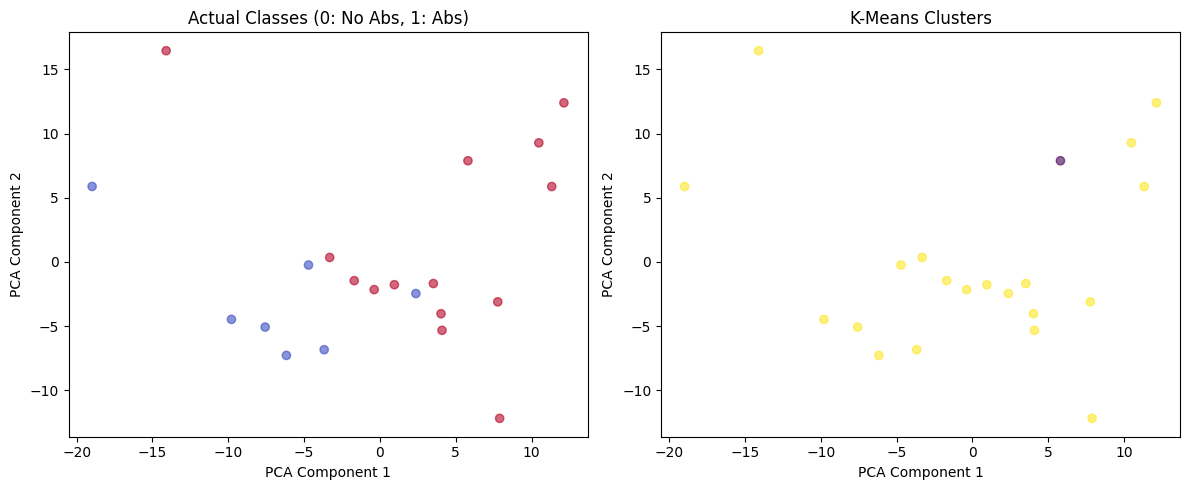


Validation Accuracy: 100.00%


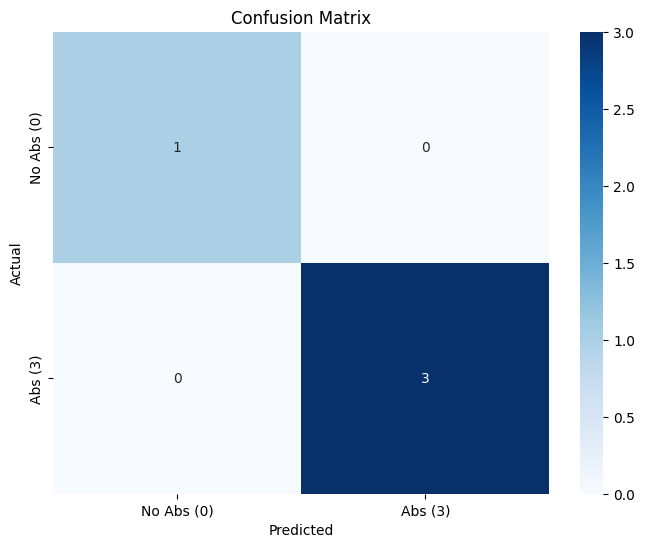


Classification Report:
              precision    recall  f1-score   support

  No Abs (0)       1.00      1.00      1.00         1
     Abs (3)       1.00      1.00      1.00         3

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4


Models saved successfully!


Saving Screenshot 2025-08-09 090537.png to Screenshot 2025-08-09 090537.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


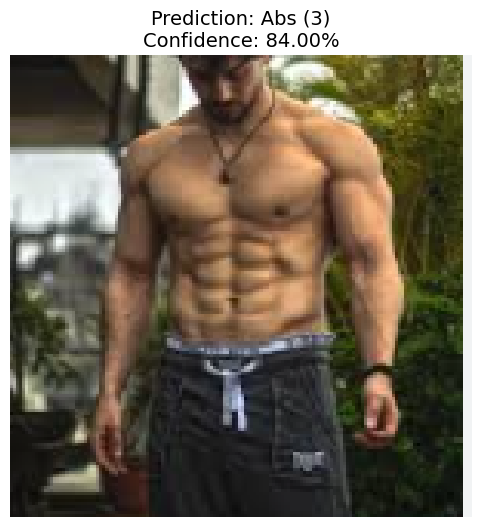

Image: Screenshot 2025-08-09 090537.png
Prediction: Abs (3)
Confidence: 84.00%


In [ ]:
# Mount Google Drive to access your data
from google.colab import drive
drive.mount('/content/drive')

# Install required packages
!pip install tensorflow scikit-learn matplotlib opencv-python

# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import os
import joblib
import seaborn as sns

# Define dataset path
DATASET_PATH = '/content/drive/MyDrive/data'  # Update to your data folder path

# Check folder structure
print("Contents of dataset directory:")
print(os.listdir(DATASET_PATH))
print(f"\nNumber of '0' (no abs) images: {len(os.listdir(os.path.join(DATASET_PATH, '0')))}")
print(f"Number of '3' (abs) images: {len(os.listdir(os.path.join(DATASET_PATH, '3')))}")

# Create data generators
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    classes=['0', '3'],  # Explicitly define class order
    subset='training')

validation_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    classes=['0', '3'],  # Explicitly define class order
    subset='validation')

# Display class indices
print("\nClass indices:", train_generator.class_indices)  # Should show {'0': 0, '3': 1}

# Load pre-trained VGG16 model for feature extraction
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
feature_extractor = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)

# Function to extract features
def extract_features(generator, sample_count):
    features = np.zeros(shape=(sample_count, 4 * 4 * 512))  # VGG16 block5_pool output
    labels = np.zeros(shape=(sample_count))
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = feature_extractor.predict(inputs_batch)
        features[i * len(inputs_batch): (i + 1) * len(inputs_batch)] = features_batch.reshape(len(inputs_batch), -1)
        labels[i * len(inputs_batch): (i + 1) * len(inputs_batch)] = labels_batch
        i += 1
        if i * len(inputs_batch) >= sample_count:
            break
    return features, labels

# Extract features
train_features, train_labels = extract_features(train_generator, train_generator.samples)
validation_features, validation_labels = extract_features(validation_generator, validation_generator.samples)

print(f"\nTrain features shape: {train_features.shape}")
print(f"Validation features shape: {validation_features.shape}")

# Perform K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(train_features)

# Visualize clusters using PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
train_features_pca = pca.fit_transform(train_features)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(train_features_pca[:, 0], train_features_pca[:, 1], c=train_labels, cmap='coolwarm', alpha=0.6)
plt.title("Actual Classes (0: No Abs, 1: Abs)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

plt.subplot(1, 2, 2)
plt.scatter(train_features_pca[:, 0], train_features_pca[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.title("K-Means Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.tight_layout()
plt.show()

# Train Random Forest classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(train_features, train_labels)

# Evaluate on validation set
val_predictions = classifier.predict(validation_features)
val_accuracy = accuracy_score(validation_labels, val_predictions)
print(f"\nValidation Accuracy: {val_accuracy:.2%}")

# Display confusion matrix
cm = confusion_matrix(validation_labels, val_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Abs (0)', 'Abs (3)'],
            yticklabels=['No Abs (0)', 'Abs (3)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Display classification report
print("\nClassification Report:")
print(classification_report(validation_labels, val_predictions,
                          target_names=['No Abs (0)', 'Abs (3)']))

# Save models for future use
feature_extractor.save('/content/drive/MyDrive/abs_detection_models/feature_extractor.h5')
joblib.dump(classifier, '/content/drive/MyDrive/abs_detection_models/classifier.pkl')
print("\nModels saved successfully!")

# Function to predict on a new image
def predict_abs(img_path):
    # Load and preprocess image
    img = load_img(img_path, target_size=(150, 150))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Extract features
    features = feature_extractor.predict(img_array)
    features = features.reshape(1, -1)

    # Predict class
    prediction = classifier.predict(features)[0]
    probability = classifier.predict_proba(features)[0]

    # Map prediction to label
    label = "No Abs (0)" if prediction == 0 else "Abs (3)"
    confidence = probability.max()

    return label, confidence, img

# Upload and test a new image
from google.colab import files
uploaded = files.upload()

for filename in uploaded.keys():
    # Predict on uploaded image
    label, confidence, img = predict_abs(filename)

    # Display the image with prediction
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.title(f"Prediction: {label}\nConfidence: {confidence:.2%}", fontsize=14)
    plt.axis('off')
    plt.show()

    print(f"Image: {filename}")
    print(f"Prediction: {label}")
    print(f"Confidence: {confidence:.2%}")